In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pprint

%matplotlib inline

pd.options.display.max_colwidth = -1

This notebook is for Chapter 3 Exercise 4, build a spam classifier.

The spam data I got from some Metis notes.

## Load Data

In [2]:
# Load data
train = pd.read_table('datasets/spam/spam_train.csv')
test = pd.read_table('datasets/spam/spam_test.csv')

# Mark spam as 1 and ham as 0
train.label.replace(['spam', 'ham'], [1,0], inplace=True)
test.label.replace(['spam', 'ham'], [1,0], inplace=True)

X_train, y_train = train.text, train.label
X_test, y_test = test.text, test.label

In [3]:
# Check class balance

print train.label.value_counts(normalize=True), '\n'
print test.label.value_counts(normalize=True)

0    0.865997
1    0.134003
Name: label, dtype: float64 

0    0.865757
1    0.134243
Name: label, dtype: float64


## EDA

In [4]:
X_train

0       Early bird! Any purchases yet?                                                                                                                                                                                                 
1       Hi, this is Mandy Sullivan calling from HOTMIX FM...you are chosen to receive £5000.00 in our Easter Prize draw.....Please telephone 09041940223 to claim before 29/03/05 or your prize will be transferred to someone else....
2       Heart is empty without love.. Mind is empty without wisdom.. Eyes r empty without dreams &amp; Life is empty without frnds.. So Alwys Be In Touch. Good night &amp; sweet dreams                                               
3       Yes I started to send requests to make it but pain came back so I'm back in bed. Double coins at the factory too. I gotta cash in all my nitros.                                                                               
4       I'll see if I can swing by in a bit, got some things to take car

## Modeling

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### Preprocessing

In [8]:
# revisit: punctuation, stopwords, URLs, numbers, n_grams, etc
# extras: count length of each doc, look at caps/lowercase

preprocess_pipeline = Pipeline([
                        #('tfidf', TfidfVectorizer(max_df = .9))
                        ('count_vec', CountVectorizer(binary=True, max_df = .9))
    ])

## Train Models

### Naive Bayes

In [9]:
nb_pipeline = Pipeline([
                            ('prep', preprocess_pipeline),
                            ('nb', BernoulliNB())
    ])

nb_cv = GridSearchCV(nb_pipeline, param_grid={}, cv=4, n_jobs=-1, scoring='roc_auc')
nb_cv.fit(X_train, y_train)


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('prep', Pipeline(steps=[('count_vec', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.9, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None...ocabulary=None))])), ('nb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

### SVM

In [10]:
svm_pipeline = Pipeline([
                            ('tfidf', TfidfVectorizer(max_df = .9)),
                            ('svm', SVC(kernel='linear')),
    ])

svm_cv = GridSearchCV(svm_pipeline, param_grid={'svm__C':[.03, .1, .3, 1]}, cv=3, n_jobs=-1, scoring='roc_auc')
svm_cv.fit(X_train, y_train)
print svm_cv.best_params_
print svm_cv.grid_scores_

{'svm__C': 1}
[mean: 0.99169, std: 0.00336, params: {'svm__C': 0.03}, mean: 0.99170, std: 0.00337, params: {'svm__C': 0.1}, mean: 0.99348, std: 0.00250, params: {'svm__C': 0.3}, mean: 0.99435, std: 0.00142, params: {'svm__C': 1}]


//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### Random Forest

In [11]:
rf_pipeline = Pipeline([
                            ('prep', preprocess_pipeline),
                            ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1))
    ])

rf_cv = GridSearchCV(rf_pipeline, param_grid={'rf__min_samples_leaf':[1,3,9,30]}, cv=4, n_jobs=-1, scoring='roc_auc')
rf_cv.fit(X_train, y_train)
print rf_cv.best_params_

{'rf__min_samples_leaf': 1}


## Evalute models

In [88]:
def print_model_metrics(cv_object, model_name):
    if hasattr(cv_object, 'predict_proba'):
        scores = cv_object.predict_proba(X_train)[:,1]
    else:
        scores = cv_object.decision_function(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, scores)
    print model_name.upper()
    print 'Best average ROC score: %f' % cv_object.best_score_
    print 'Accuracy on test data: %f\n' % accuracy_score(y_test, cv_object.predict(X_test))
    plt.plot(fpr, tpr, label=model_name)
    plt.title('ROC Curve for Training Data')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.legend()

    
def plot_feature_importances(feature_importance, vocab, n_features):
    """
    Makes a barplot of the top n features and their feature_importances (a la random forest)
    feature_importance: list or array of values
    vocab: list or array of words
    n_features: number of features to plot
    """
    assert len(feature_importance) == len(vocab), 'feature_importance and vocab must be of equal length'
    if isinstance(feature_importance, list):
        feature_importance = np.array(feature_importance)
    if isinstance(vocab, list):
        vocab = np.array(vocab)
    
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    sorted_feature_importance = feature_importance[sorted_idx][-n_features:]
    sorted_vocab = vocab[sorted_idx][-n_features:]
    pos = np.arange(n_features) + .5
    fig = plt.figure(figsize=(5, n_features/3))
    plt.barh(pos, sorted_feature_importance, align='center')
    plt.yticks(pos, sorted_vocab)
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    
    

NAIVE BAYES
Best average ROC score: 0.996224
Accuracy on test data: 0.977028

SVM
Best average ROC score: 0.994351
Accuracy on test data: 0.984925

RF
Best average ROC score: 0.994280
Accuracy on test data: 0.978464



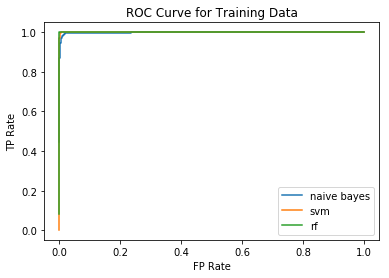

In [13]:
print_model_metrics(nb_cv, 'naive bayes')
print_model_metrics(svm_cv, 'svm')
print_model_metrics(rf_cv, 'rf')

## Which words are most predictive?

### In Random Forest:

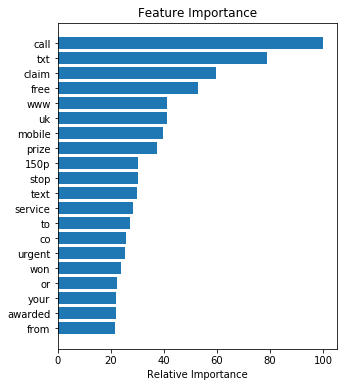

In [89]:
feature_importance = rf_cv.best_estimator_.named_steps['rf'].feature_importances_
vocab = rf_cv.best_estimator_.named_steps['prep'].named_steps['count_vec'].get_feature_names()
plot_feature_importances(feature_importance, vocab, 20)

## Notes:  
Potential ideas:  
- finish the section below on "digging into naive bayes results"  
-- plot conditional probs with NB like I plotted feature importances with RF  
-- consider that I already wrote functions at Metis for showing feature importances and sorting coefficients...  
-- write a function that lets me input some text and find out which words from my models are contributing the most to my predictions
- scrap this data and use the more difficult stuff from the handson book

In [49]:
vocab = nb_cv.best_estimator_.named_steps['prep'].named_steps['count_vec'].get_feature_names()
cond_probs = np.exp(nb_cv.best_estimator_.named_steps['nb'].feature_log_prob_)
spam_ham_ratio = cond_probs[1,:]/cond_probs[0,:]
labeled_ratios = zip(vocab, spam_ham_ratio)
sorted_labeled_ratios = sorted(labeled_ratios, key=lambda x: x[1])

In [90]:
print 'Words much more common in spam than ham:'
pprint.pprint(sorted_labeled_ratios[-20:])

Words much more common in spam than ham:
[(u'weekly', 122.41814946619213),
 (u'mob', 135.30427046263344),
 (u'collection', 141.7473309608541),
 (u'apply', 148.1903914590747),
 (u'valid', 148.1903914590747),
 (u'www', 148.1903914590747),
 (u'000', 154.63345195729536),
 (u'uk', 167.51957295373663),
 (u'150ppm', 173.96263345195729),
 (u'tone', 193.29181494661921),
 (u'1000', 199.73487544483984),
 (u'awarded', 206.17793594306048),
 (u'cs', 206.17793594306048),
 (u'500', 225.50711743772234),
 (u'16', 244.83629893238427),
 (u'guaranteed', 257.72241992882562),
 (u'18', 264.16548042704625),
 (u'150p', 347.92526690391458),
 (u'prize', 451.01423487544497),
 (u'claim', 547.66014234875445)]


In [91]:
print 'Words much more common in ham than spam:'
pprint.pprint(sorted_labeled_ratios[:20])

Words much more common in ham than spam:
[(u'lt', 0.033910844727477053),
 (u'gt', 0.034090267186352587),
 (u'he', 0.047029638673143345),
 (u'lor', 0.055543624984660693),
 (u'da', 0.061362480935434685),
 (u'later', 0.070033266285006945),
 (u'come', 0.073634977122521567),
 (u'oh', 0.074919308118844688),
 (u'she', 0.07954395676815601),
 (u'doing', 0.087068385111089677),
 (u'ask', 0.10392033061646193),
 (u'morning', 0.10392033061646193),
 (u'said', 0.1092044152240786),
 (u'amp', 0.11108724996932139),
 (u'cos', 0.11303614909159017),
 (u'lol', 0.11303614909159017),
 (u'something', 0.11505465175393995),
 (u'anything', 0.1171465545131025),
 (u'sure', 0.1171465545131025),
 (u'nice', 0.12156717921171012)]


In [43]:
test['pred'] = nb_cv.predict(X_test)

In [47]:
test[test.label==1].iloc[:20,:]

,label,text,pred
12,1,Urgent! Please call 09061213237 from landline. £5000 cash or a luxury 4* Canary Islands Holiday await collection. T&Cs SAE PO Box 177. M227XY. 150ppm. 16+,1
21,1,"Congrats! 2 mobile 3G Videophones R yours. call 09061744553 now! videochat wid ur mates, play java games, Dload polyH music, noline rentl. bx420. ip4. 5we. 150pm",1
44,1,Adult 18 Content Your video will be with you shortly,0
49,1,"YOU 07801543489 are guaranteed the latests Nokia Phone, a 40GB iPod MP3 player or a £500 prize! Txt word:COLLECT to No:83355! TC-LLC NY-USA 150p/Mt msgrcvd18+",1
51,1,"HOT LIVE FANTASIES call now 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call",1
67,1,PRIVATE! Your 2004 Account Statement for 07742676969 shows 786 unredeemed Bonus Points. To claim call 08719180248 Identifier Code: 45239 Expires,1
74,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
78,1,WIN a £200 Shopping spree every WEEK Starting NOW. 2 play text STORE to 88039. SkilGme. TsCs08714740323 1Winawk! age16 £1.50perweeksub.,1
92,1,"Think ur smart ? Win £200 this week in our weekly quiz, text PLAY to 85222 now!T&Cs WinnersClub PO BOX 84, M26 3UZ. 16+. GBP1.50/week",1
96,1,Hi 07734396839 IBH Customer Loyalty Offer: The NEW NOKIA6600 Mobile from ONLY £10 at TXTAUCTION!Txt word:START to No:81151 & get Yours Now!4T&,1


In [117]:
for w, p in labeled_ratios:
    if w == 'call':
        print w, p

call 10.1586904788


In [118]:
test_array = nb_cv.best_estimator_.named_steps['prep'].named_steps['count_vec'].transform(test.text[51:53]). \
    todense()[0,:]
test_array = np.asarray(test_array).flatten()

In [119]:
np.array(labeled_ratios)[test_array==1, :]

array([[u'0870', u'51.5444839858'],
       [u'08707509020', u'38.6583629893'],
       [u'1327', u'45.1014234875'],
       [u'20p', u'57.987544484'],
       [u'5wb', u'45.1014234875'],
       [u'box', u'24.6983985765'],
       [u'call', u'10.1586904788'],
       [u'cr9', u'45.1014234875'],
       [u'croydon', u'45.1014234875'],
       [u'fantasies', u'38.6583629893'],
       [u'hot', u'15.4633451957'],
       [u'is', u'1.44898522122'],
       [u'just', u'1.97299460233'],
       [u'live', u'9.37172436105'],
       [u'ltd', u'90.2028469751'],
       [u'min', u'10.3804863582'],
       [u'national', u'103.088967972'],
       [u'now', u'4.30513587836'],
       [u'ntt', u'51.5444839858'],
       [u'per', u'20.5006470398'],
       [u'po', u'47.2491103203'],
       [u'rate', u'49.396797153']],
      dtype='<U28')

In [83]:
np.array(labeled_ratios)[test_array.T==1, :]

IndexError: too many indices for array

In [107]:
labeled_ratios[:10]

[(u'raining', 64.430604982206404),
 (u'todays', 154.63345195729536),
 (u'msgs', 19.329181494661924),
 (u'yellow', 12.88612099644128),
 (u'150ppermesssubscription', 12.88612099644128),
 (u'four', 12.88612099644128),
 (u'nottingham', 12.88612099644128),
 (u'woods', 3.2215302491103195),
 (u'asian', 38.65836298932382),
 (u'hanging', 25.772241992882563)]

In [103]:
test.text[51:53]

51    HOT LIVE FANTASIES call now 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call
52    on a Tuesday night r u 4 real                                                                                             
Name: text, dtype: object

In [110]:
np.array(vocab)[test_array==1]

array([u'fingers', u'china', u'rt', u'olage', u'vitamin', u'b4190604',
       u'spare', u'appointment', u'08717205546', u'location', u'asks',
       u'forgiven', u'granite', u'fall', u'08000839402', u'aquarius',
       u'thgt', u'convincing', u'paces', u'applausestore', u'bahamas',
       u'downloads'],
      dtype='<U28')

In [111]:
nb_cv.best_estimator_.named_steps['prep'].named_steps['count_vec'].vocabulary_

{u'raining': 5357,
 u'todays': 6716,
 u'msgs': 4453,
 u'yellow': 7453,
 u'150ppermesssubscription': 295,
 u'four': 2844,
 u'nottingham': 4662,
 u'woods': 7352,
 u'asian': 1037,
 u'hanging': 3190,
 u'6pm': 578,
 u'captain': 1577,
 u'6ph': 577,
 u'esplanade': 2527,
 u'increase': 3519,
 u'buddy': 1485,
 u'electricity': 2449,
 u'scold': 5744,
 u'seriously': 5826,
 u'presents': 5202,
 u'swat': 6429,
 u'unnecessarily': 6949,
 u'lord': 4052,
 u'rp176781': 5635,
 u'savings': 5724,
 u'sleepingwith': 6015,
 u'delhi': 2137,
 u'callin': 1552,
 u'kudi': 3833,
 u'61200': 549,
 u'sufficient': 6364,
 u'chik': 1709,
 u'neway': 4586,
 u'hearin': 3251,
 u'screaming': 5758,
 u'disturb': 2255,
 u'prize': 5234,
 u'andre': 910,
 u'skills': 5997,
 u'companies': 1839,
 u'wednesday': 7200,
 u'lst': 4092,
 u'heading': 3243,
 u'clothes': 1776,
 u'10k': 258,
 u'force': 2818,
 u'specially': 6155,
 u'nigh': 4602,
 u'tired': 6687,
 u'snuggles': 6069,
 u'clubmoby': 1780,
 u'japanese': 3659,
 u'elections': 2448,
 u'sec

In [113]:
nb_cv.best_estimator_.named_steps['prep'].named_steps['count_vec'].get_feature_names()

[u'00',
 u'000',
 u'008704050406',
 u'0089',
 u'0121',
 u'01223585236',
 u'01223585334',
 u'0125698789',
 u'02',
 u'0207',
 u'02072069400',
 u'02073162414',
 u'02085076972',
 u'021',
 u'03',
 u'04',
 u'05',
 u'050703',
 u'0578',
 u'06',
 u'07',
 u'07008009200',
 u'07046744435',
 u'07090298926',
 u'07099833605',
 u'07123456789',
 u'0721072',
 u'07734396839',
 u'07753741225',
 u'0776xxxxxxx',
 u'07781482378',
 u'07786200117',
 u'077xxx',
 u'078',
 u'07808247860',
 u'07808726822',
 u'07815296484',
 u'07821230901',
 u'078498',
 u'07880867867',
 u'07946746291',
 u'0796xxxxxx',
 u'07973788240',
 u'07xxxxxxxxx',
 u'08',
 u'0800',
 u'08000407165',
 u'08000776320',
 u'08000839402',
 u'08000930705',
 u'08000938767',
 u'08001950382',
 u'08002888812',
 u'08002986030',
 u'08002986906',
 u'08002988890',
 u'08006344447',
 u'0808',
 u'08081263000',
 u'08081560665',
 u'0825',
 u'083',
 u'0844',
 u'08448350055',
 u'08448714184',
 u'0845',
 u'08452810073',
 u'08452810075over18',
 u'0870',
 u'08700469649'